# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

#for using deque option to peform avergaing of line parameters across serveral pictures in a video
from collections import deque 

%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


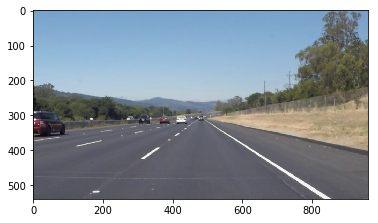

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    
    #use the improved frame_draw_lines
    frame_draw_lines(line_img, lines, thickness = 10)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Additional Helper Functions

In [4]:
def show_images(images, cmap=None):
    """
    This function helps to display mutliple test images
    """
    cols = 2
    rows = (len(images)+1)//cols #find the integer number of rows
    
    plt.figure(figsize=(15, 16))
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(img.shape)==2 else cmap
        plt.imshow(img, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    
class Line:
    """
    This class definition helps to create an object with 2 lists
    viz., slope and interecept. The list use degue option to store
    `maxlen` items using first-in first-out protocol. 
    
    The cleanall function is used to clear the contents in the lists
    """
    def __init__(self):
        self.slope = deque(maxlen = 300)     #store the slope parameters
        self.intercept = deque(maxlen = 300) #store the intercept parameters
        self.length = deque(maxlen = 300)    #store the length of line
        
    def cleanall(self):
        self.slope = deque(maxlen = 300)     
        self.intercept = deque(maxlen = 300)
        self.length = deque(maxlen = 300)

left = Line()   #object of class Line to store the parameters of left lanes
right = Line()  #object of class Line to store the parameters of right lanes

def frame_draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: This is an improved function over the draw_lines function  
    
    Line segments are separated by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, the average position of each of 
    the lines are computed and extrapolated to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    left_slope = [] #store the slope of left lines
    right_slope = [] #store the slope of right lines
    
    left_intercept = [] #store the intercepts of left lines
    right_intercept = [] #store the intercepts of right lines
    
    left_length = [] #store the length of left lines
    right_length = [] #store the length of right lines
    
    imshape = img.shape
    # y parameters to extrapolate the left and right lines
    fy1 = imshape[0]
    fy2 = int(0.61*imshape[0])
    
    if lines is None: #if there are no lines then return dont proceed further
        return
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            intercept = y2 -slope*x2
            length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
            if slope < 0: # because y is increasing from top to btm
                left.slope.append(slope)
                left.intercept.append(intercept)
                left.length.append(length)
            else:
                right.slope.append(slope)
                right.intercept.append(intercept)
                right.length.append(length)

    #compute the weighted average for the slopes and intercepts of the left and the right lanes, respectively
    #the length of linea are used as weights
    left_slope = np.dot(left.slope,left.length)/np.sum(left.length) 
    left_intercept = np.dot(left.intercept, left.length)/np.sum(left.length)
    right_slope = np.dot(right.slope,right.length)/np.sum(right.length)
    right_intercept = np.dot(right.intercept, right.length)/np.sum(right.length)
    
    #now we have the averaged slopes and intercepts of left and right lines
    left_x1 = int((fy1-left_intercept)/left_slope)
    left_x2 = int((fy2-left_intercept)/left_slope)
    cv2.line(img, (left_x1, fy1), (left_x2, fy2), color, thickness)
    
    right_x1 = int((fy1-right_intercept)/right_slope)
    right_x2 = int((fy2-right_intercept)/right_slope)
    cv2.line(img, (right_x1, fy1), (right_x2, fy2), color, thickness)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['challenge_frame0.jpg',
 'challenge_frame3.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidWR_frame0.jpg',
 'solidWR_frame2.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidYL_frame0.jpg',
 'solidYL_frame8.jpg',
 'whiteCarLaneSwitch.jpg']

# Display the test images

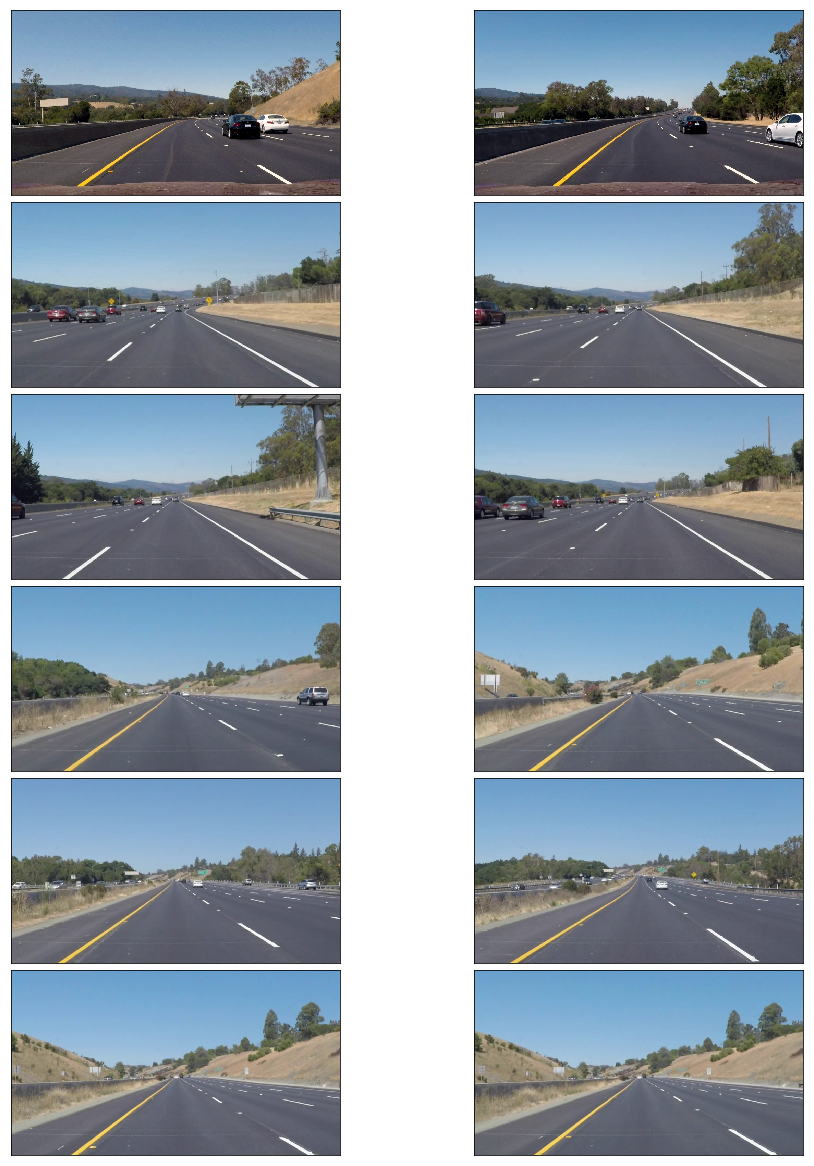

In [6]:
file_list = os.listdir("test_images/") # stores the names of the test images in file_list
images = [mpimg.imread("test_images/"+a) for a in file_list ] #reads the image files into the list named images
show_images(images)

# Region of Interest
Marking out the region for detection of lane lines is extremely crucial for the lane detection. We tried several parameters for the quadrilateral before arriving at the final parameters. The parameters of the quadrilateral were choosen to satisfy all the test images

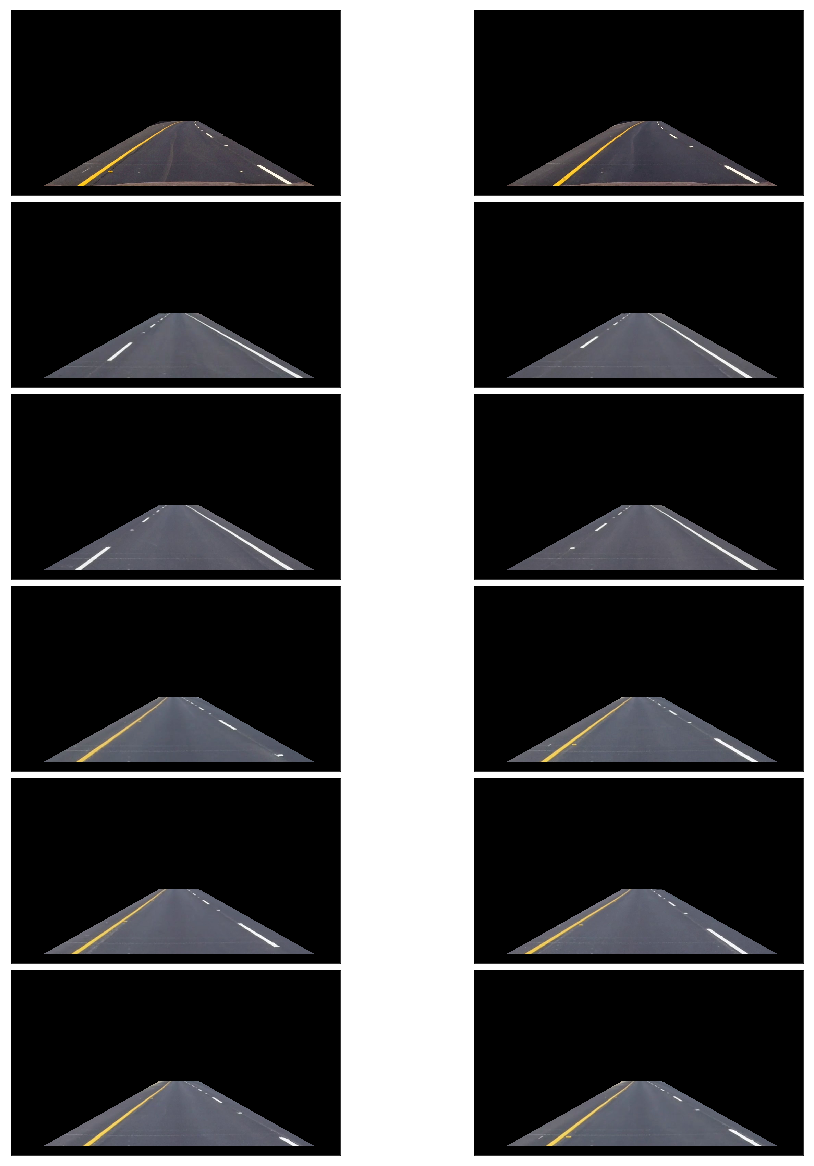

In [7]:
def quad_of_interest(img):
    """
    This function places the quadrilateral on the test images.
    This quadrilateral will be the region of interest where we detect the lines.
    """
    
    imshape = img.shape
    rs, cs = imshape[:2]
    vertices = np.array([[(0.10*cs, 0.95*rs),(0.45*cs,0.6*rs), (0.57*cs,0.6*rs), (0.92*cs, 0.95*rs)]], dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

quad_images = [quad_of_interest(a) for a in images]

show_images(quad_images)

# saving the images to test_images_output folder
for i, fname in enumerate(file_list):
    file_name = "test_images_output/quad_"+fname
    mpimg.imsave(file_name,quad_images[i])

# Detection of Line Edges
In the following, we tune the parameters of `gaussian_blur` and `canny` to detect the line edges in the area of interest

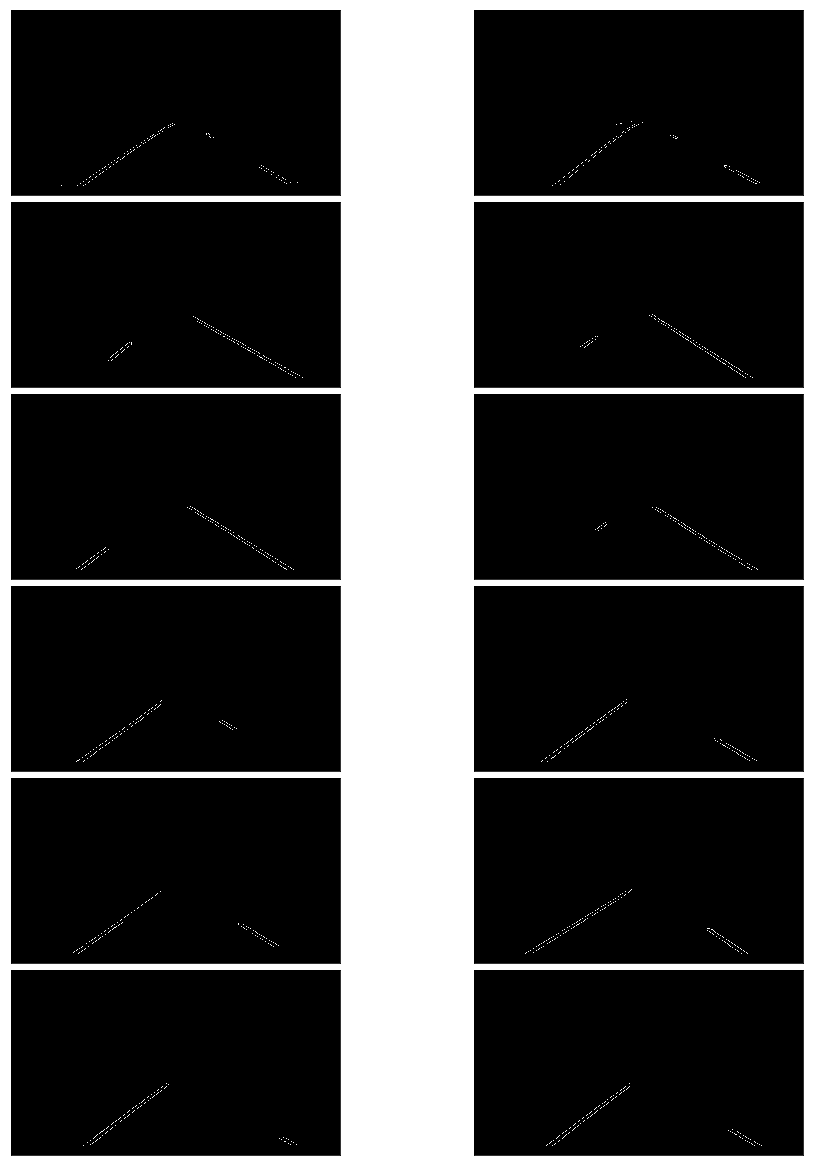

In [8]:
def detect_lines(img):
    
    """
    This function detect the line edges in the image
    we repeat the code lines in `quad_of_interest` function
    """
    
    imshape = img.shape
    rs, cs = imshape[:2]
    vertices = np.array([[(0.10*cs, 0.95*rs),(0.45*cs,0.6*rs), (0.57*cs,0.6*rs), (0.92*cs, 0.95*rs)]], dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    gray_img = grayscale(img) #obtian the gray scale of image
    gaussblur_img = gaussian_blur(img, kernel_size=19) #perform gaussian blurring on the image
    low_threshold = 50
    high_threshold = 50*3
    canny_edges = canny(gaussblur_img, low_threshold, high_threshold)
    masked_img = region_of_interest(canny_edges, vertices)
    
    return masked_img

edge_images = [detect_lines(a) for a in images]
show_images(edge_images)

# saving the images to test_images_output folder
for i, fname in enumerate(file_list):
    file_name = "test_images_output/edge_"+fname
    mpimg.imsave(file_name,edge_images[i])

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

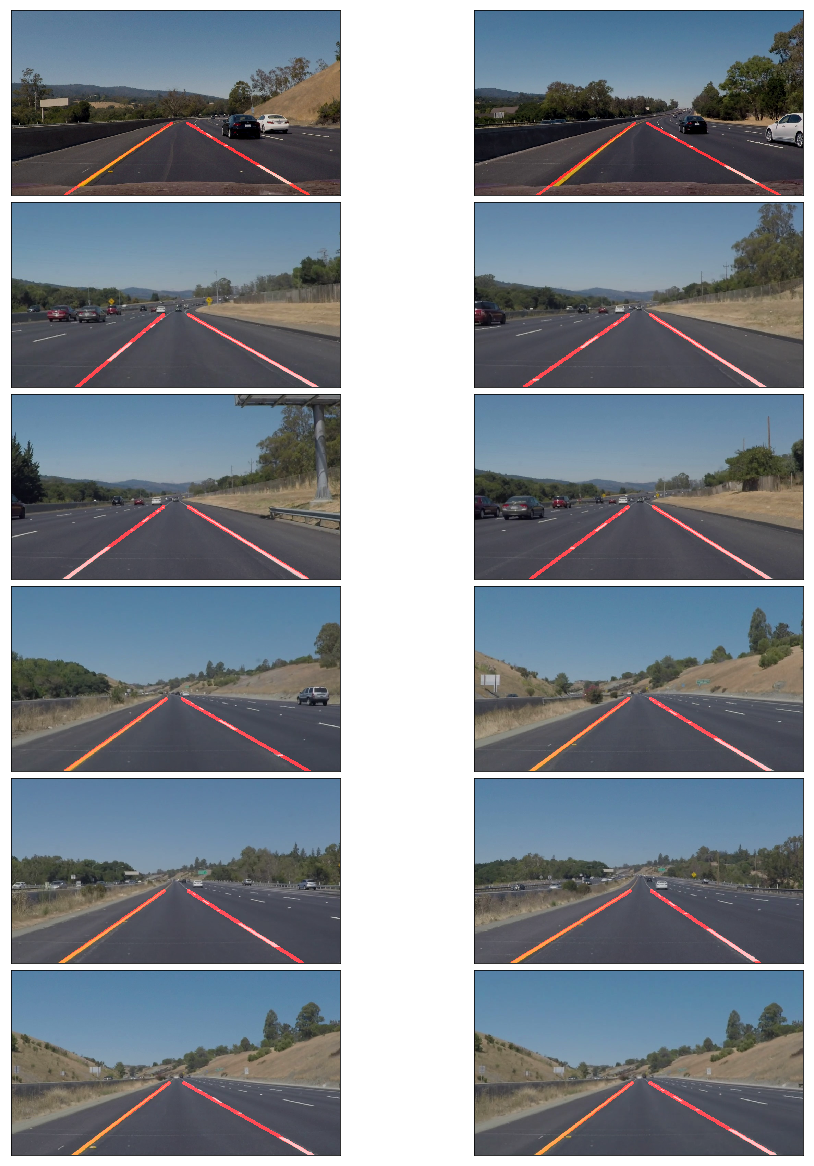

In [9]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def pipeline(img):
    
    #clear the lists to get rid of the line parameters from the previous images
    left.cleanall()
    right.cleanall()
    
    gray_img = grayscale(img) #obtian the gray scale of image
    gaussblur_img = gaussian_blur(img, kernel_size=19) #perform gaussian blurring on the image
    
    #dedect edges
    low_threshold = 50
    high_threshold = 50*3
    canny_edges = canny(gaussblur_img, low_threshold, high_threshold)
  
    #obtain the region of interest in the image
    imshape = img.shape
    rs, cs = imshape[:2]
    vertices = np.array([[(0.10*cs, 0.95*rs),(0.45*cs,0.6*rs), (0.57*cs,0.6*rs), (0.92*cs, 0.95*rs)]], dtype=np.int32)
    masked_img = region_of_interest(canny_edges, vertices) #obtain the masked region of interest in grayscale
    
    #detect the line
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45    # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10 #minimum number of pixels making up a line
    max_line_gap = 50   # maximum gap in pixels between connectable line segments
    line_img = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)
    
    output = weighted_img(line_img, img, α=0.8, β=1., λ=0.)
    return output

line_images = [pipeline(a) for a in images]
show_images(line_images)

# saving the images to test_images_output folder
for i, fname in enumerate(file_list):
    file_name = "test_images_output/line_"+fname
    mpimg.imsave(file_name,line_images[i])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    gray_img = grayscale(img) #obtian the gray scale of image
    gaussblur_img = gaussian_blur(img, kernel_size=19) #perform gaussian blurring on the image
    
    #dedect edges
    low_threshold = 50
    high_threshold = 50*3
    canny_edges = canny(gaussblur_img, low_threshold, high_threshold)
  
    imshape = img.shape
    rs, cs = imshape[:2]
    vertices = np.array([[(0.10*cs, 0.95*rs),(0.45*cs,0.6*rs), (0.57*cs,0.6*rs), (0.92*cs, 0.95*rs)]], dtype=np.int32)
    masked_img = region_of_interest(canny_edges, vertices) #obtain the masked region of interest in grayscale
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 90     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10 #minimum number of pixels making up a line
    max_line_gap = 50   # maximum gap in pixels between connectable line segments
    
    lines = cv2.HoughLinesP(masked_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
   
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    frame_draw_lines(line_img, lines, thickness=10)

    result = weighted_img(line_img, img, α=0.8, β=1., λ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [12]:
#clear the lists to get rid of the line parameters from the previous images
left.cleanall()
right.cleanall()

white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 57.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 5.08 s, sys: 388 ms, total: 5.47 s
Wall time: 4.22 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
#clear the lists to get rid of the line parameters from the previous images
left.cleanall()
right.cleanall()

yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:13<00:00, 52.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 17.1 s, sys: 1.4 s, total: 18.5 s
Wall time: 13.4 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
#clear the lists to get rid of the line parameters from the previous images
left.cleanall()
right.cleanall()

challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:09<00:00, 26.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 11.2 s, sys: 1.16 s, total: 12.3 s
Wall time: 9.93 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))